In [1]:
 !pip install osmnx folium ortools networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.

Loading road network...
Network loaded: 25,683 nodes.
Running Experiment 1/30...
Running Experiment 2/30...
Running Experiment 3/30...
Running Experiment 4/30...
Running Experiment 5/30...
Running Experiment 6/30...
Running Experiment 7/30...
Running Experiment 8/30...
Running Experiment 9/30...
Running Experiment 10/30...
Running Experiment 11/30...
Running Experiment 12/30...
Running Experiment 13/30...
Running Experiment 14/30...
Running Experiment 15/30...
Running Experiment 16/30...
Running Experiment 17/30...
Running Experiment 18/30...
Running Experiment 19/30...
Running Experiment 20/30...
Running Experiment 21/30...
Running Experiment 22/30...
Running Experiment 23/30...
Running Experiment 24/30...
Running Experiment 25/30...
Running Experiment 26/30...
Running Experiment 27/30...
Running Experiment 28/30...
Running Experiment 29/30...
Running Experiment 30/30...

📊 ALGORITHM PERFORMANCE SUMMARY
Greedy Wins: 1/30 (3.3%)
OR-Tools Wins: 27/30 (90.0%)
GA Wins: 2/30 (6.7%)

Averag

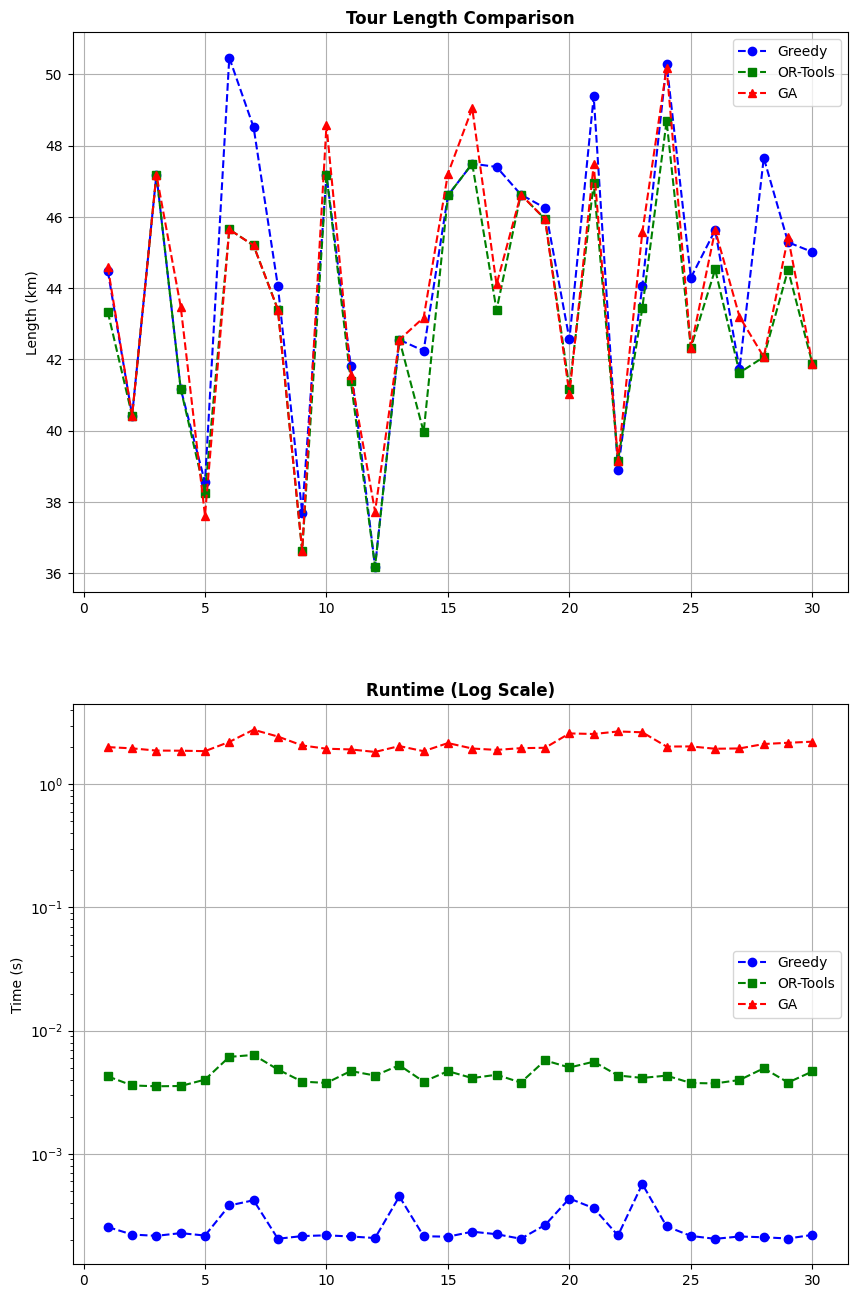

In [8]:
import numpy as np
import pandas as pd
import folium
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
import time
import matplotlib.pyplot as plt
from math import radians, cos, sin, sqrt, atan2
import os
from sklearn.cluster import KMeans

# --- CONFIGURATION ---
N_EXPERIMENTS = 30
N_DISTRICTS = 10
N_RAW_POINTS = 60
BURSA_CENTER = (40.19, 29.06)
DISTANCE_WEIGHT = "length"

MASTER_SEED = 42

AVG_DRIVING_SPEED_KMH = 30
AVG_DRIVING_SPEED_MPS = AVG_DRIVING_SPEED_KMH * 1000 / 3600

GA_POPULATION_SIZE = 100
GA_GENERATIONS = 200
GA_MUTATION_RATE = 0.02
GA_ELITE_SIZE = 10

DISTRICT_COLORS = ['red', 'blue', 'green', 'purple', 'orange',
                   'darkgreen', 'darkblue', 'cadetblue', 'darkred', 'gray']

# --- NETWORK LOADING ---
print("Loading road network...")
G = ox.graph_from_point(BURSA_CENTER, dist=7000, network_type='drive')
print(f"Network loaded: {len(G.nodes):,} nodes.")

# --- HELPERS ---
def haversine_dist_m(lat1, lon1, lat2, lon2):
    """Calculates haversine distance in meters."""
    R = 6371000
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def generate_random_points(center_lat, center_lon, n_points, max_dist_km=5):
    """Generates random coordinates within a radius."""
    points = []
    for _ in range(n_points):
        dist = np.random.uniform(0, max_dist_km * 1000)
        angle = np.random.uniform(0, 2 * np.pi)
        lat_offset = (dist / 111320) * cos(angle)
        lon_offset = (dist / (111320 * cos(radians(center_lat)))) * sin(angle)
        points.append([center_lat + lat_offset, center_lon + lon_offset])
    return np.array(points)

def create_distance_matrix(G, nodes):
    """Creates a distance matrix based on shortest network paths."""
    n = len(nodes)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j: continue
            try:
                dist = nx.shortest_path_length(G, nodes[i], nodes[j], weight=DISTANCE_WEIGHT)
                dist_matrix[i][j] = dist
            except:
                dist_matrix[i][j] = 999999
    return dist_matrix

# --- TSP ALGORITHMS ---
def greedy_insertion(dist_matrix):
    n = len(dist_matrix)
    if n <= 1: return [0], 0.0
    tour = [0]
    unvisited = set(range(1, n))
    while unvisited:
        min_cost = float('inf')
        best_k, best_pos = None, None
        for k in unvisited:
            for i in range(len(tour)):
                j = (i + 1) % len(tour)
                cost = (dist_matrix[tour[i]][k] + dist_matrix[k][tour[j]] - dist_matrix[tour[i]][tour[j]])
                if cost < min_cost:
                    min_cost, best_k, best_pos = cost, k, i + 1
        tour.insert(best_pos, best_k)
        unvisited.remove(best_k)
    return tour, sum(dist_matrix[tour[i]][tour[(i+1)%n]] for i in range(n))

def or_tools_tsp(dist_matrix):
    n = len(dist_matrix)
    if n <= 1: return [0], 0.0

    manager = pywrapcp.RoutingIndexManager(n, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(i, j):
        ni = manager.IndexToNode(i)
        nj = manager.IndexToNode(j)
        return int(dist_matrix[ni][nj] * 1000)

    transit = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit)

    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    params.time_limit.seconds = 10

    solution = routing.SolveWithParameters(params)

    if solution:
        idx = routing.Start(0)
        tour = []
        while not routing.IsEnd(idx):
            tour.append(manager.IndexToNode(idx))
            idx = solution.Value(routing.NextVar(idx))
        return tour, solution.ObjectiveValue() / 1000.0

    return None, float('inf')

def ordered_crossover(parent1, parent2):
    n = len(parent1)
    p1 = parent1[1:]
    p2 = parent2[1:]
    cx_point1, cx_point2 = sorted(np.random.choice(len(p1), 2, replace=False))
    child = [-1] * len(p1)
    child[cx_point1:cx_point2] = p1[cx_point1:cx_point2]
    remaining = [city for city in p2 if city not in child]
    idx = 0
    for i in range(len(p1)):
        if child[i] == -1:
            child[i] = remaining[idx]
            idx += 1
    return [0] + child

def swap_mutation(tour):
    tour = tour.copy()
    idx1, idx2 = np.random.choice(range(1, len(tour)), 2, replace=False)
    tour[idx1], tour[idx2] = tour[idx2], tour[idx1]
    return tour

def genetic_algorithm_tsp(dist_matrix, pop_size=GA_POPULATION_SIZE, generations=GA_GENERATIONS,
                          mutation_rate=GA_MUTATION_RATE, elite_size=GA_ELITE_SIZE):
    n = len(dist_matrix)
    if n <= 1: return [0], 0.0

    def fitness(tour):
        return sum(dist_matrix[tour[i]][tour[(i+1)%n]] for i in range(n))

    def create_individual():
        tour = list(range(1, n))
        np.random.shuffle(tour)
        return [0] + tour

    population = [create_individual() for _ in range(pop_size)]
    best_tour, best_length = None, float('inf')

    for gen in range(generations):
        fitness_scores = [(fitness(ind), ind) for ind in population]
        fitness_scores.sort(key=lambda x: x[0])
        if fitness_scores[0][0] < best_length:
            best_length, best_tour = fitness_scores[0][0], fitness_scores[0][1].copy()

        new_population = [ind.copy() for _, ind in fitness_scores[:elite_size]]
        while len(new_population) < pop_size:
            tournament_size = 5
            indices = np.random.choice(len(population), tournament_size * 2, replace=False)
            t1, t2 = indices[:tournament_size], indices[tournament_size:]
            parent1 = min([population[i] for i in t1], key=lambda x: fitness(x))
            parent2 = min([population[i] for i in t2], key=lambda x: fitness(x))
            child = ordered_crossover(parent1, parent2)
            if np.random.random() < mutation_rate:
                child = swap_mutation(child)
            new_population.append(child)
        population = new_population

    return best_tour, best_length

# --- VISUALIZATION ---
def create_map(G, tour, district_nodes, raw_points, point_labels, centroids, algorithm, length, runtime, filename, exp_num):
    m = folium.Map(location=[BURSA_CENTER[0], BURSA_CENTER[1]], zoom_start=12)

    for idx, point in enumerate(raw_points):
        cluster_id = point_labels[idx]
        color = DISTRICT_COLORS[cluster_id % len(DISTRICT_COLORS)]
        folium.CircleMarker(location=point, radius=3, color=color, fill=True, fillColor=color, fillOpacity=0.6).add_to(m)

    if tour and district_nodes:
        for i in range(N_DISTRICTS):
            cluster_points = raw_points[point_labels == i]
            center_lat, center_lon = centroids[i]
            max_dist_m = max([haversine_dist_m(center_lat, center_lon, p[0], p[1]) for p in cluster_points]) if len(cluster_points) > 0 else 0
            radius_to_draw = max(max_dist_m + 50, 200)
            node = district_nodes[i]
            lat, lon = G.nodes[node]['y'], G.nodes[node]['x']
            color = DISTRICT_COLORS[i % len(DISTRICT_COLORS)]
            folium.Circle(location=[lat, lon], radius=radius_to_draw, color=color, fill=True, fillColor=color, fillOpacity=0.1, weight=1).add_to(m)
            folium.Marker(location=[lat, lon], icon=folium.Icon(color=color, icon='star', prefix='fa')).add_to(m)

        for i in range(len(tour)):
            u, v = district_nodes[tour[i]], district_nodes[tour[(i + 1) % len(tour)]]
            try:
                path_nodes = nx.shortest_path(G, u, v, weight=DISTANCE_WEIGHT)
                full_path_coords = []
                for k in range(len(path_nodes) - 1):
                    edge_data = G.get_edge_data(path_nodes[k], path_nodes[k+1])[0]
                    if 'geometry' in edge_data:
                        full_path_coords.extend([(lat, lon) for lon, lat in edge_data['geometry'].coords])
                    else:
                        p1, p2 = G.nodes[path_nodes[k]], G.nodes[path_nodes[k+1]]
                        full_path_coords.extend([(p1['y'], p1['x']), (p2['y'], p2['x'])])
                folium.PolyLine(full_path_coords, color='darkred' if i < len(tour) - 1 else 'green', weight=4, opacity=0.8).add_to(m)
            except: pass

    legend = f'''
    <div style="position: fixed; top: 10px; left: 50px; width: 350px; background: white; border: 2px solid grey; z-index: 9999; padding: 12px; font-size: 14px; border-radius: 5px;">
        <h4 style="margin-top:0;">{algorithm}</h4>
        <b>Distance:</b> {length/1000:.2f} km<br>
        <b>Runtime:</b> {runtime:.4f} s<br>
        <b>Duration by Car (30km/h):</b> {length/AVG_DRIVING_SPEED_MPS/60:.1f} min<br>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend))
    m.save(filename)

# --- MAIN LOOP ---
os.makedirs('experiments', exist_ok=True)
results = []

for exp in range(1, N_EXPERIMENTS + 1):
    print(f"Running Experiment {exp}/{N_EXPERIMENTS}...")
    np.random.seed(MASTER_SEED + exp)

    raw_points = generate_random_points(BURSA_CENTER[0], BURSA_CENTER[1], N_RAW_POINTS)
    kmeans = KMeans(n_clusters=N_DISTRICTS, n_init=10, random_state=MASTER_SEED + exp).fit(raw_points)
    centroids, labels = kmeans.cluster_centers_, kmeans.labels_

    district_nodes = []
    for c in centroids:
        try: district_nodes.append(ox.distance.nearest_nodes(G, c[1], c[0]))
        except: pass

    if len(district_nodes) < N_DISTRICTS: continue

    dist_matrix = create_distance_matrix(G, district_nodes)

    t0 = time.time(); g_tour, g_len = greedy_insertion(dist_matrix); g_time = time.time() - t0
    t0 = time.time(); o_tour, o_len = or_tools_tsp(dist_matrix); o_time = time.time() - t0
    t0 = time.time(); ga_tour, ga_len = genetic_algorithm_tsp(dist_matrix); ga_time = time.time() - t0

    if g_len > 200000 or o_len > 200000 or ga_len > 200000: continue

    if exp == 1 or exp % 5 == 0:
        create_map(G, g_tour, district_nodes, raw_points, labels, centroids, "Greedy", g_len, g_time, f'experiments/exp_{exp:02d}_greedy.html', exp)
        create_map(G, o_tour, district_nodes, raw_points, labels, centroids, "OR-Tools", o_len, o_time, f'experiments/exp_{exp:02d}_ortools.html', exp)
        create_map(G, ga_tour, district_nodes, raw_points, labels, centroids, "Genetic Algo", ga_len, ga_time, f'experiments/exp_{exp:02d}_genetic.html', exp)

    results.append({
        'Experiment': exp,
        'Greedy Tour (units)': g_len/1000, 'Greedy Time (s)': g_time,
        'OR-Tools Tour (units)': o_len/1000, 'OR-Tools Time (s)': o_time,
        'GA Tour (units)': ga_len/1000, 'GA Time (s)': ga_time
    })

# --- ANALYSIS & PLOTTING ---
valid = pd.DataFrame(results)
if not valid.empty:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16))

    ax1.plot(valid['Experiment'], valid['Greedy Tour (units)'], 'o--', label='Greedy', color='blue')
    ax1.plot(valid['Experiment'], valid['OR-Tools Tour (units)'], 's--', label='OR-Tools', color='green')
    ax1.plot(valid['Experiment'], valid['GA Tour (units)'], '^--', label='GA', color='red')
    ax1.set_title('Tour Length Comparison', fontweight='bold')
    ax1.set_ylabel('Length (km)')
    ax1.legend(); ax1.grid(True)

    ax2.plot(valid['Experiment'], valid['Greedy Time (s)'], 'o--', label='Greedy', color='blue')
    ax2.plot(valid['Experiment'], valid['OR-Tools Time (s)'], 's--', label='OR-Tools', color='green')
    ax2.plot(valid['Experiment'], valid['GA Time (s)'], '^--', label='GA', color='red')
    ax2.set_yscale('log')
    ax2.set_title('Runtime (Log Scale)', fontweight='bold')
    ax2.set_ylabel('Time (s)')
    ax2.legend(); ax2.grid(True)

    plt.savefig('tsp_comparison.png')
    valid.to_csv('tsp_results.csv', index=False)

    print("\n" + "="*60 + "\n📊 ALGORITHM PERFORMANCE SUMMARY\n" + "="*60)
    wins = {'Greedy': 0, 'OR-Tools': 0, 'GA': 0}
    for _, row in valid.iterrows():
        best = min(row['Greedy Tour (units)'], row['OR-Tools Tour (units)'], row['GA Tour (units)'])
        if row['Greedy Tour (units)'] == best: wins['Greedy'] += 1
        if row['OR-Tools Tour (units)'] == best: wins['OR-Tools'] += 1
        if row['GA Tour (units)'] == best: wins['GA'] += 1

    for algo, count in wins.items():
        print(f"{algo} Wins: {count}/{len(valid)} ({count/len(valid)*100:.1f}%)")

    print(f"\nAverage Lengths:\nGreedy: {valid['Greedy Tour (units)'].mean():.2f} km\nOR-Tools: {valid['OR-Tools Tour (units)'].mean():.2f} km\nGA: {valid['GA Tour (units)'].mean():.2f} km")
    print("="*60)

In [7]:
import shutil
from google.colab import files

# Klasörü zip haline getir
shutil.make_archive('/content/experiments', 'zip', '/content/experiments')

# Zip dosyasını indir
files.download('/content/experiments.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>